### Audio t-SNE

This notebook will show you how to create a t-SNE plot of a group of audio clips. Along the way, we'll cover a few basic audio processing and machine learning tasks.

We will make two separate t-SNE plots. The first is clustering a group of many audio files in a single directory. The second one takes only a single audio track (a song) as it's input, segments it into many audio chunks (and saves them to a directory) and clusters the resulting chunks.

This notebook requires numpy, matplotlib, scikit-learn, and [librosa](https://github.com/librosa/librosa) to run. To install librosa, run the following command in the terminal:

    pip install librosa

After verifying you have the required libraries, verify the following import commands work.

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.manifold import TSNE
import json

First we need to scan some directory of audio files and collect all their paths into a single list. This notebook is using a free sample pack called "Vintage drum machines" which can be downloaded, along with all the other data needed for ml4a-guides, by running the script `download.sh` in the `data` folder, or downloaded and unzipped manually from [http://ivcloud.de/index.php/s/QyDXk1EDYDTVYkF](http://ivcloud.de/index.php/s/QyDXk1EDYDTVYkF).

Once you've done that, or changed the `path` variable to another directory of audio samples on your computer, you can proceed with the next code block to load all the filepaths into memory.

In [38]:
path = '/Users/chris/Desktop/retro_samples'


files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d .wav files in %s"%(len(files),path))



found 155 .wav files in /Users/chris/Desktop/retro_samples


In the next block, we're going to create a function which extracts a feature vector from an audio file. We are using [librosa](https://github.com/librosa/librosa/), a python library for audio analysis and music information retrieval, to handle the feature extraction.

The function we're creating `get_features` will take a waveform `y` at a sample rate `sr`, and extract features for only the first second of the audio. It is possible to use longer samples, but because we are interested in clustering according to sonic similarity, we choose to focus on short samples with relatively homogenous content over their durations. Longer samples have different sections and would require somewhat more sophisticated feature extraction.

The feature extraction will calculate the first 13 [mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) of the audio file, as well as their first- and second-order derivatives, and concatenate them into a single 39-element feature vector. The feature vector is also [standardized](https://en.wikipedia.org/wiki/Standard_score) so that each feature has equal variance.

In [23]:
def get_features(y, sr):
    y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

Now we will iterate through all the files, and get their feature vectors, placing them into a new list `feature_vectors`. We also make a new array `sound_paths` to index the feature vectors to the correct paths, in case some of the files are empty or corrupted (as they are in the `Vintage Drum Machines` sample pack), or otherwise something goes wrong in analyzing them.

In [60]:
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    if i % 100 == 0:
        print("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f)
        if len(y) < 2:
            print("error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except:
        print("error loading %s" % f)
        
#print("calculated %d feature vectors"%len(feature_vectors))


get 1 of 155 = /Users/chris/Desktop/retro_samples/RDM_TapeB_SY1-Snr03.wav
get 101 of 155 = /Users/chris/Desktop/retro_samples/RDM_Copicat_MT40-Snr02.wav
[-6.16054692e+00  5.34728004e-02  1.46220608e-01  1.08196871e-01
  1.62274667e-01  1.67878199e-01  1.65449119e-01  1.88422936e-01
  1.57725603e-01  1.95600530e-01  1.66991329e-01  1.97535583e-01
  1.81068505e-01  1.37445681e-03  2.07659934e-01  1.75523145e-01
  1.89546721e-01  1.70862219e-01  1.68959857e-01  1.70335466e-01
  1.62216616e-01  1.71099467e-01  1.59644188e-01  1.69003335e-01
  1.59271061e-01  1.62657496e-01  1.92022886e-01  1.63844628e-01
  1.67358918e-01  1.65496016e-01  1.67507049e-01  1.67710086e-01
  1.67333682e-01  1.68305234e-01  1.67982857e-01  1.68614100e-01
  1.67792963e-01  1.68529424e-01  1.69058365e-01]


Now we can run t-SNE over the feature vectors to get a 2-dimensional embedding of our audio files. We use scikit-learn's TSNE function, and additionally normalize the results so that they are between 0 and 1.

([array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 34.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 29.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 29.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 31.,  0.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  

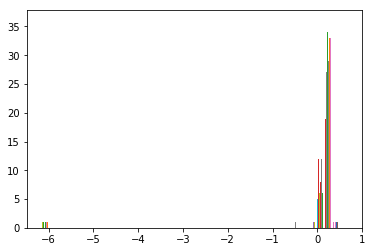

In [98]:
##print(feature_vectors[12])
#np.histogram(feature_vectors[12])

diagram = np.array(feature_vectors[2])
plt.hist(feature_vectors, bins=39) 

In [94]:
model = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(feature_vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.000s...
[t-SNE] Computed neighbors for 155 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.075282
[t-SNE] Computed conditional probabilities in 0.025s
[t-SNE] Iteration 50: error = 56.9339790, gradient norm = 0.6266300 (50 iterations in 0.232s)
[t-SNE] Iteration 100: error = 54.2756882, gradient norm = 0.6474406 (50 iterations in 0.206s)
[t-SNE] Iteration 150: error = 54.1188316, gradient norm = 0.6752255 (50 iterations in 0.225s)
[t-SNE] Iteration 200: error = 57.5678673, gradient norm = 0.5573191 (50 iterations in 0.236s)
[t-SNE] Iteration 250: error = 56.9339676, gradient norm = 0.5951747 (50 iterations in 0.248s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.933968
[t-SNE] Iteration 300: error = 0.3351575, gradient norm = 0.0073945 (50 iterations in 0.223s)
[t-SNE] Iteration 350: error = 0.1235708, gradient norm = 0.0018420 (

Let's plot our t-SNE points.  We can use matplotlib to quickly scatter them and see their distribution.

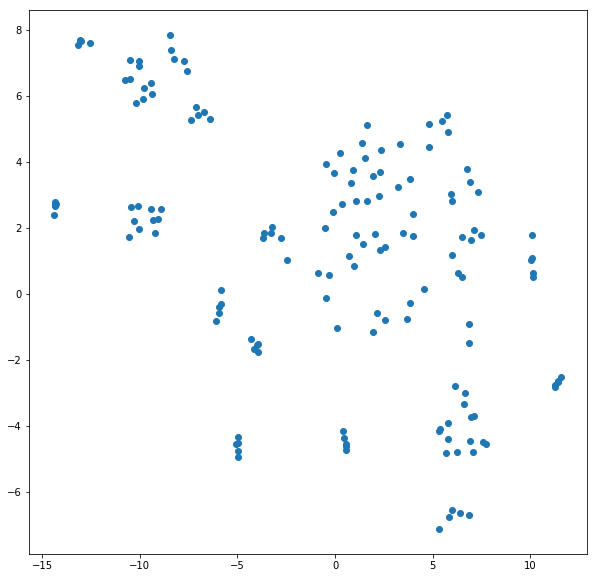

In [95]:
x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize = (10,10))
plt.scatter(x_axis, y_axis)
plt.show()

We see our t-SNE plot of our audio files, but it's not particularly interesting! Since we are dealing with audio files, there's no easy way to compare neighboring audio samples to each other. We can use some other, more interactive environment to view the results of the t-SNE. One way we can do this is by saving the results to a JSON file which stores the filepaths and t-SNE assignments of all the audio files. We can then load this JSON file in another environment. 

One example of this is provided in the "AudioTSNEViewer" application in [ml4a-ofx](https://github.com/ml4a/ml4a-ofx/tree/master/apps). This is an [openFrameworks](http://openframeworks.cc) application which loads all the audio clips into an interactive 2d grid (using the t-SNE layout) and lets you play each sample by hovering your mouse over it.  

In any case, to save the t-SNE to a JSON file, we first normalize the coordinates to between 0 and 1 and save them, along with the full filepaths.

In [7]:
tsne_path = "../data/example-audio-tSNE.json"

x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"path":os.path.abspath(f), "point":[x, y]} for f, x, y in zip(sound_paths, x_norm, y_norm)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile, cls=MyEncoder)

print("saved %s to disk!" % tsne_path)

saved ../data/example-audio-tSNE.json to disk!


Now what about if we want to do this same analysis, but instead of analyzing a directory of individual audio clips, we want to cut up a _single audio file_ into many chunks and cluster those instead. 

We can add a few extra lines of code to the above in order to do this. First let's select a piece of audio. Find any song on your computer that you want to do this analysis to and set a path to it.

In [14]:
source_audio = '/Users/chris/Desktop/ml/lit.m4a'

What we will now do is use librosa to calculate the _onsets_ of our audio file. Onsets are the timestamps to the beginning of discrete sonic events in our audio. We set the hop_length (number of samples for each frame) to 512. 

In [15]:
hop_length = 512
y, sr = librosa.load(source_audio)
onsets = librosa.onset.onset_detect(y=y, sr=sr, hop_length=hop_length)

How do we interpret these numbers?  Initially our original audio, at a sample rate `sr` is divided up into bins which each cointain 512 samples (specified by `hop_length` in the onset detection function). The onset numbers are an index to each of these bins. So for example, if the first onset is 20, this corresponds to sample 20 * 512 = 10,240. Given a sample rate of 22050, this corresponds to 10250/22050 = 0.46 seconds into the track.

We can view the onsets as vertical lines on top of the waveform using matplotlib and the following code.

Text(0.5,1,'Wavefile with 5362 onsets plotted')

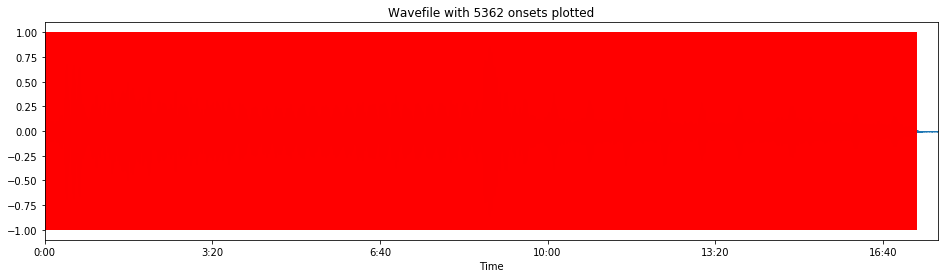

In [19]:
times = [hop_length * onset / sr for onset in onsets]

plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.vlines(times, -1, 1, color='r', alpha=0.9, label='Onsets')
plt.title('Wavefile with %d onsets plotted' % len(times))

Now what we will do is, we will go through each of the detected onsets, and crop the original audio to the interval from that onset until the next one. We will create a new folder, `../data/audio_clips`, into which we will then save all of the individual audio clips, and extract the same feature vector we described above for our new audio sample.

In [26]:
# where to save our new clips to
path_save_intervals = "/Users/chris/Desktop/ml/snippets"

# make new directory to save them 
if not os.path.isdir(path_save_intervals):
    os.mkdir(path_save_intervals)
    


# grab each interval, extract a feature vector, and save the new clip to our above path
feature_vectors = []
for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ] * hop_length  # first sample of the interval
    idx_y2 = onsets[i+1] * hop_length  # last sample of the interval
    y_interval = y[idx_y1:idx_y2]
    features = get_features(y_interval, sr)   # get feature vector for the audio clip between y1 and y2
    file_path = '%s/onset_%d.wav' % (path_save_intervals, i)   # where to save our new audio clip
    feature_vectors.append({"file":file_path, "features":features})   # append to a feature vector
    librosa.output.write_wav(file_path, y_interval, sr)   # save to disk



In [27]:
# save results to this json file
tsne_path = "/Users/chris/Desktop/ml/tsne/onsets.json"

# feature_vectors has both the features and file paths in it. let's pull out just the feature vectors
features_matrix = [f["features"] for f in feature_vectors]

# calculate a t-SNE and normalize it
model = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(features_matrix)
x_axis, y_axis = model[:,0], model[:,1] # normalize t-SNE
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"path":os.path.abspath(f['file']), "point":[float(x), float(y)]} for f, x, y in zip(feature_vectors, x_norm, y_norm)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved %s to disk!" % tsne_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5361 samples in 0.012s...
[t-SNE] Computed neighbors for 5361 samples in 0.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5361
[t-SNE] Computed conditional probabilities for sample 2000 / 5361
[t-SNE] Computed conditional probabilities for sample 3000 / 5361
[t-SNE] Computed conditional probabilities for sample 4000 / 5361
[t-SNE] Computed conditional probabilities for sample 5000 / 5361
[t-SNE] Computed conditional probabilities for sample 5361 / 5361
[t-SNE] Mean sigma: 0.104290
[t-SNE] Computed conditional probabilities in 0.228s
[t-SNE] Iteration 50: error = 87.4162750, gradient norm = 0.0315033 (50 iterations in 40.640s)
[t-SNE] Iteration 100: error = 77.5143661, gradient norm = 0.0012581 (50 iterations in 38.907s)
[t-SNE] Iteration 150: error = 77.1483231, gradient norm = 0.0001700 (50 iterations in 38.567s)
[t-SNE] Iteration 200: error = 77.1179428, gradient norm = 0.0000434 (50 iterations in 36.720s

Let's plot the results on another scatter plot. One nice thing we can do is color the points according to their order in the original track. 

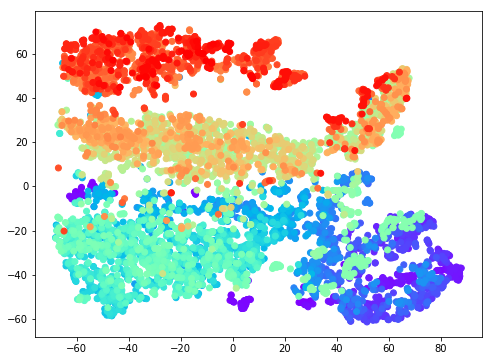

In [28]:
colors = cm.rainbow(np.linspace(0, 1, len(x_axis)))
plt.figure(figsize = (8,6))
plt.scatter(x_axis, y_axis, color=colors)
plt.show()

Not surprisingly, audio clips which appear close to each other (and therefore have a similar color) also cluster together in the t-SNE. Two clips that are right next to each other probably have similar sound content and therefore similar feature vectors. But we also see different sections (e.g. teal and orange) appearing clustered together as well. This suggests those two sections may have similar audio content as well.